In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
datadir = "/content/drive/MyDrive/CS444/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/CS444/assignment3/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/.shortcut-targets-by-id/1SiOppoI7q01cVeV1zD-zgQQXtCWPtaUS/CS444/assignment3


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image
import torchvision.transforms.functional as TF

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot==1:
      return TF.rotate(img, 90)
    elif rot==2:
      return TF.rotate(img, 180)
    elif rot==3:
      return TF.rotate(img, 270)    
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)


testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# import matplotlib.pyplot as plt

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# rot_classes = ('0', '90', '180', '270')


# def imshow(img):
#     # unnormalize
#     img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img) #Whitening the input image,it reduces the effect of variations in brightness and contrast between images.
#     img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img) #rescaling the pixel values back to their original range of [0, 255]
#     #These values correspond to the mean and standard deviation of the CIFAR-10 dataset, and are used to 
#     #normalize the pixel values so that they have a mean of 0 and a standard deviation of 1.
#     npimg = img.numpy() #converts the image tensor to a NumPy array 
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transposes the dimensions so that the image is in the format (height, width, channels) instead of the PyTorch format (channels, height, width)
#     plt.show()


# dataiter = iter(trainloader)
# images, rot_images, rot_labels, labels = next(dataiter)

# # print images and rotated images
# img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
# print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
# img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
# print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

In [6]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)
#

In [11]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    acc=100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return acc

In [12]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels                      
            if task=="rotation":
              imgs=imgs_rotated.to(device)
              labels=rotation_label.to(device)
            elif task=='classification':
              imgs=imgs.to(device)  
              labels=cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs=net(imgs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _,predicted = torch.max(outputs.data,1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)
        
    net.eval()
    acc=run_test(net,testloader,criterion,task)
    return acc
    print('Finished Training')

In [13]:
import matplotlib.pyplot as plt
def image_show():
    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    rot_classes = ('0', '90', '180', '270')


    def imshow(img):
        # unnormalize
        img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img) #Whitening the input image,it reduces the effect of variations in brightness and contrast between images.
        img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img) #rescaling the pixel values back to their original range of [0, 255]
        #These values correspond to the mean and standard deviation of the CIFAR-10 dataset, and are used to 
        #normalize the pixel values so that they have a mean of 0 and a standard deviation of 1.
        npimg = img.numpy() #converts the image tensor to a NumPy array 
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transposes the dimensions so that the image is in the format (height, width, channels) instead of the PyTorch format (channels, height, width)
        plt.show()


    dataiter = iter(trainloader)
    images, rot_images, rot_labels, labels = next(dataiter)

    # print images and rotated images
    img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
    print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
    img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
    print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

subset_size: 20


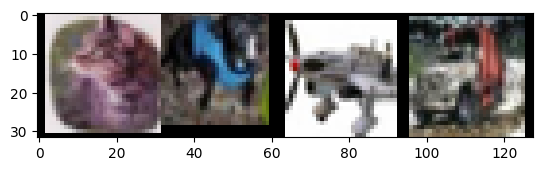

Class labels:  cat   dog   plane truck


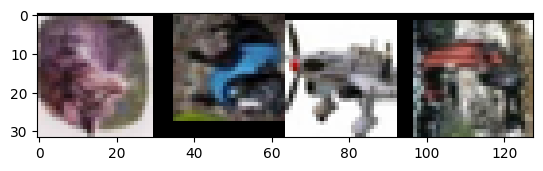

Rotation labels:  180   270   0     90   
TESTING:
Accuracy of the network on the 10000 test images: 24.47 %
Average loss on the 10000 test images: 7956.603
TESTING:
Accuracy of the network on the 10000 test images: 24.65 %
Average loss on the 10000 test images: 237609.891
TESTING:
Accuracy of the network on the 10000 test images: 25.49 %
Average loss on the 10000 test images: 346023.531
TESTING:
Accuracy of the network on the 10000 test images: 25.45 %
Average loss on the 10000 test images: 43681.016
TESTING:
Accuracy of the network on the 10000 test images: 24.98 %
Average loss on the 10000 test images: 10063.053
TESTING:
Accuracy of the network on the 10000 test images: 25.31 %
Average loss on the 10000 test images: 4045.102
TESTING:
Accuracy of the network on the 10000 test images: 25.80 %
Average loss on the 10000 test images: 3252.212
TESTING:
Accuracy of the network on the 10000 test images: 24.93 %
Average loss on the 10000 test images: 848.859
TESTING:
Accuracy of the network 

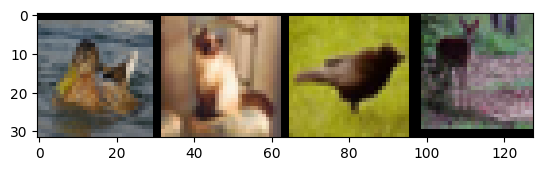

Class labels:  bird  cat   bird  deer 


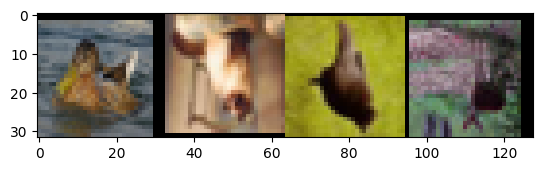

Rotation labels:  0     180   270   180  
TESTING:
Accuracy of the network on the 10000 test images: 25.91 %
Average loss on the 10000 test images: 64.150
TESTING:
Accuracy of the network on the 10000 test images: 25.66 %
Average loss on the 10000 test images: 49.043
TESTING:
Accuracy of the network on the 10000 test images: 24.89 %
Average loss on the 10000 test images: 10.492
TESTING:
Accuracy of the network on the 10000 test images: 28.17 %
Average loss on the 10000 test images: 16.813
TESTING:
Accuracy of the network on the 10000 test images: 34.22 %
Average loss on the 10000 test images: 5.480
TESTING:
Accuracy of the network on the 10000 test images: 35.21 %
Average loss on the 10000 test images: 1.353
TESTING:
Accuracy of the network on the 10000 test images: 40.71 %
Average loss on the 10000 test images: 1.287
TESTING:
Accuracy of the network on the 10000 test images: 42.46 %
Average loss on the 10000 test images: 1.226
TESTING:
Accuracy of the network on the 10000 test images:

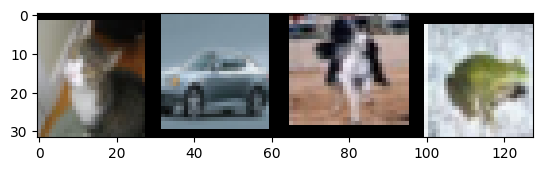

Class labels:  cat   car   horse frog 


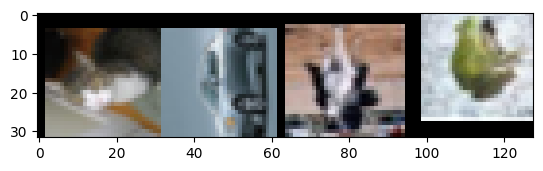

Rotation labels:  90    90    180   90   
TESTING:
Accuracy of the network on the 10000 test images: 43.59 %
Average loss on the 10000 test images: 1.437
TESTING:
Accuracy of the network on the 10000 test images: 45.34 %
Average loss on the 10000 test images: 1.377
TESTING:
Accuracy of the network on the 10000 test images: 46.84 %
Average loss on the 10000 test images: 1.165
TESTING:
Accuracy of the network on the 10000 test images: 47.82 %
Average loss on the 10000 test images: 1.179
TESTING:
Accuracy of the network on the 10000 test images: 48.98 %
Average loss on the 10000 test images: 1.123
TESTING:
Accuracy of the network on the 10000 test images: 47.86 %
Average loss on the 10000 test images: 1.163
TESTING:
Accuracy of the network on the 10000 test images: 50.77 %
Average loss on the 10000 test images: 1.129
TESTING:
Accuracy of the network on the 10000 test images: 50.98 %
Average loss on the 10000 test images: 1.097
TESTING:
Accuracy of the network on the 10000 test images: 51.

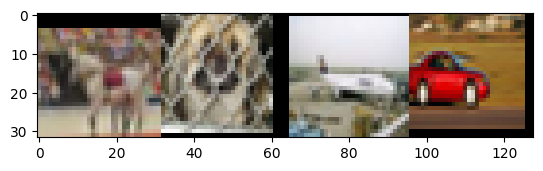

Class labels:  horse dog   plane car  


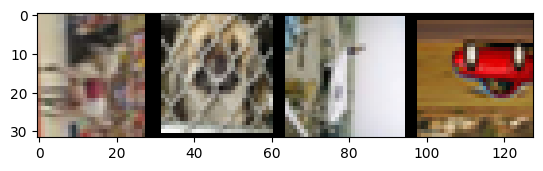

Rotation labels:  270   0     270   180  
TESTING:
Accuracy of the network on the 10000 test images: 52.86 %
Average loss on the 10000 test images: 1.148
TESTING:
Accuracy of the network on the 10000 test images: 53.83 %
Average loss on the 10000 test images: 1.109
TESTING:
Accuracy of the network on the 10000 test images: 56.00 %
Average loss on the 10000 test images: 1.026
TESTING:
Accuracy of the network on the 10000 test images: 56.02 %
Average loss on the 10000 test images: 1.037
TESTING:
Accuracy of the network on the 10000 test images: 56.69 %
Average loss on the 10000 test images: 1.066
TESTING:
Accuracy of the network on the 10000 test images: 56.69 %
Average loss on the 10000 test images: 1.034
TESTING:
Accuracy of the network on the 10000 test images: 58.25 %
Average loss on the 10000 test images: 0.983
TESTING:
Accuracy of the network on the 10000 test images: 59.03 %
Average loss on the 10000 test images: 0.979
TESTING:
Accuracy of the network on the 10000 test images: 58.

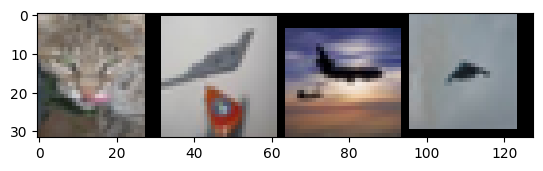

Class labels:  cat   plane plane plane


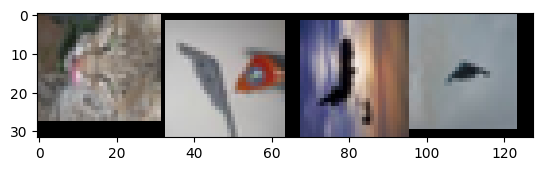

Rotation labels:  270   90    90    0    
[1,   100] loss: 0.937 acc: 60.72 time: 8.44
[1,   200] loss: 0.929 acc: 61.48 time: 9.07
[1,   300] loss: 0.925 acc: 61.12 time: 7.21
TESTING:
Accuracy of the network on the 10000 test images: 61.41 %
Average loss on the 10000 test images: 0.945
[2,   100] loss: 0.968 acc: 59.72 time: 11.40
[2,   200] loss: 0.907 acc: 62.19 time: 9.22
[2,   300] loss: 0.890 acc: 63.61 time: 7.53
TESTING:
Accuracy of the network on the 10000 test images: 63.13 %
Average loss on the 10000 test images: 0.897
[3,   100] loss: 0.890 acc: 63.02 time: 10.48
[3,   200] loss: 0.887 acc: 63.09 time: 9.79
[3,   300] loss: 0.871 acc: 64.34 time: 7.57
TESTING:
Accuracy of the network on the 10000 test images: 65.91 %
Average loss on the 10000 test images: 0.820
[4,   100] loss: 0.848 acc: 64.76 time: 9.90
[4,   200] loss: 0.873 acc: 64.19 time: 10.26
[4,   300] loss: 0.909 acc: 62.52 time: 8.88
TESTING:
Accuracy of the network on the 10000 test images: 66.36 %
Average loss

In [14]:
# Define the subset sizes to use
subset_sizes = [20,100, 500, 1000, 5000]

# Train and evaluate the model for each subset size
subset_rot_acc=[]
filtered_trainset_list=[]
indx=0
for num_examples_per_category in subset_sizes:
    print("subset_size:",num_examples_per_category)
    # Create the data loaders for the training and testing subsets
    filtered_trainset = []

# Loop over each class and select 100 examples
    for class_index in range(10):
        indices = torch.where(torch.tensor(trainset.targets) == class_index)[0][:num_examples_per_category]
        class_samples = torch.utils.data.Subset(trainset, indices)
        filtered_trainset.append(class_samples)

    filtered_trainset = torch.utils.data.ConcatDataset(filtered_trainset)
    filtered_trainset_list.append(filtered_trainset)
    trainloader = torch.utils.data.DataLoader(filtered_trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
    image_show()
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=0.001)
    acc=train(net, criterion, optimizer, num_epochs=26, decay_epochs=15, init_lr=0.01, task='rotation')
    subset_rot_acc.append(acc)
    print(acc)
    # TODO: Save the model
    s_model='my_model'+str(num_examples_per_category)+'.'+'pt'
    indx+=1
    torch.save(net.state_dict(), s_model)

In [15]:
subset_rot_acc


[36.37, 50.57, 55.4, 63.47, 74.46]

Number of training examples per category for a supervised CIFAR10 model

subset_size: 20


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


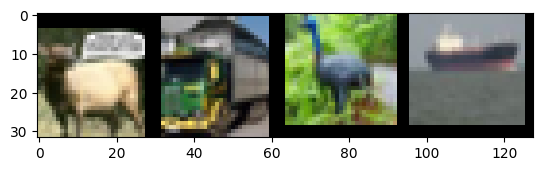

Class labels:  deer  truck bird  ship 


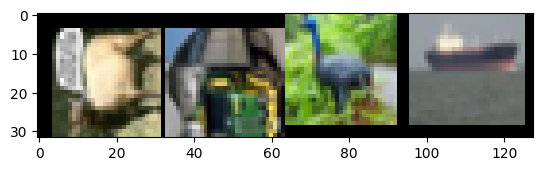

Rotation labels:  90    90    0     0    
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 71988.656
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 2158031.250
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 569015.312
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 100160.805
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 25492.805
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 9208.620
TESTING:
Accuracy of the network on the 10000 test images: 10.12 %
Average loss on the 10000 test images: 2770.493
TESTING:
Accuracy of the network on the 10000 test images: 10.68 %
Average loss on the 10000 test images: 785.558
TESTING:
Accuracy of the netwo

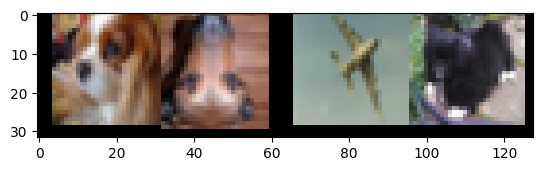

Class labels:  dog   dog   plane dog  


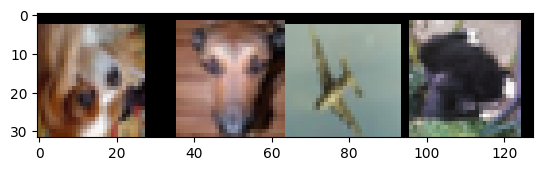

Rotation labels:  180   180   180   90   
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 146463.141
TESTING:
Accuracy of the network on the 10000 test images: 9.85 %
Average loss on the 10000 test images: 944.979
TESTING:
Accuracy of the network on the 10000 test images: 11.72 %
Average loss on the 10000 test images: 27.875
TESTING:
Accuracy of the network on the 10000 test images: 20.53 %
Average loss on the 10000 test images: 10.542
TESTING:
Accuracy of the network on the 10000 test images: 24.17 %
Average loss on the 10000 test images: 4.123
TESTING:
Accuracy of the network on the 10000 test images: 23.53 %
Average loss on the 10000 test images: 4.162
TESTING:
Accuracy of the network on the 10000 test images: 25.24 %
Average loss on the 10000 test images: 3.517
TESTING:
Accuracy of the network on the 10000 test images: 25.64 %
Average loss on the 10000 test images: 3.688
TESTING:
Accuracy of the network on the 10000 test ima

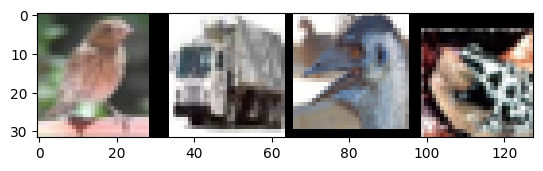

Class labels:  bird  truck bird  frog 


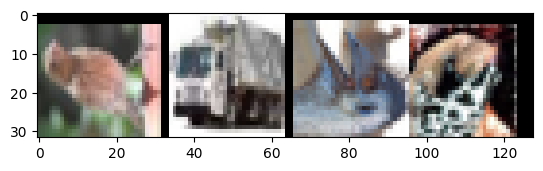

Rotation labels:  90    0     270   270  
TESTING:
Accuracy of the network on the 10000 test images: 18.47 %
Average loss on the 10000 test images: 2.265
TESTING:
Accuracy of the network on the 10000 test images: 27.15 %
Average loss on the 10000 test images: 2.255
TESTING:
Accuracy of the network on the 10000 test images: 29.60 %
Average loss on the 10000 test images: 2.056
TESTING:
Accuracy of the network on the 10000 test images: 29.09 %
Average loss on the 10000 test images: 2.020
TESTING:
Accuracy of the network on the 10000 test images: 34.54 %
Average loss on the 10000 test images: 1.769
TESTING:
Accuracy of the network on the 10000 test images: 31.61 %
Average loss on the 10000 test images: 1.960
TESTING:
Accuracy of the network on the 10000 test images: 34.26 %
Average loss on the 10000 test images: 1.960
TESTING:
Accuracy of the network on the 10000 test images: 40.34 %
Average loss on the 10000 test images: 1.708
TESTING:
Accuracy of the network on the 10000 test images: 39.

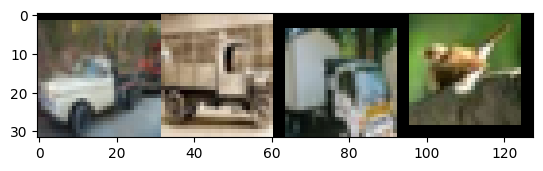

Class labels:  truck truck truck bird 


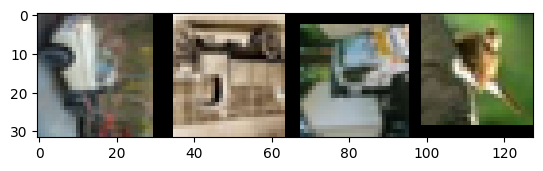

Rotation labels:  270   180   90    270  
TESTING:
Accuracy of the network on the 10000 test images: 23.67 %
Average loss on the 10000 test images: 2.161
TESTING:
Accuracy of the network on the 10000 test images: 26.06 %
Average loss on the 10000 test images: 3.058
TESTING:
Accuracy of the network on the 10000 test images: 31.63 %
Average loss on the 10000 test images: 1.863
TESTING:
Accuracy of the network on the 10000 test images: 36.42 %
Average loss on the 10000 test images: 1.678
TESTING:
Accuracy of the network on the 10000 test images: 40.05 %
Average loss on the 10000 test images: 1.671
TESTING:
Accuracy of the network on the 10000 test images: 42.70 %
Average loss on the 10000 test images: 1.815
TESTING:
Accuracy of the network on the 10000 test images: 38.82 %
Average loss on the 10000 test images: 2.228
TESTING:
Accuracy of the network on the 10000 test images: 47.44 %
Average loss on the 10000 test images: 1.443
TESTING:
Accuracy of the network on the 10000 test images: 46.

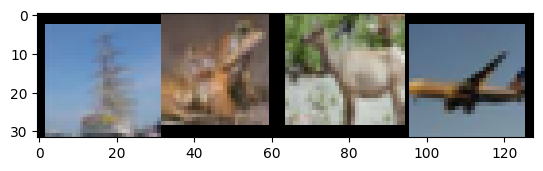

Class labels:  ship  frog  deer  plane


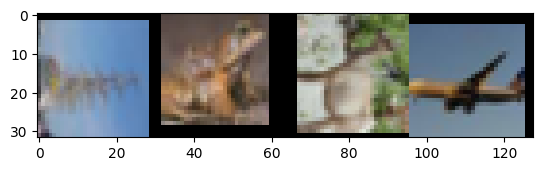

Rotation labels:  270   0     270   0    
[1,   100] loss: 2.215 acc: 24.15 time: 7.53
[1,   200] loss: 1.828 acc: 33.19 time: 9.03
[1,   300] loss: 1.683 acc: 39.29 time: 8.89
TESTING:
Accuracy of the network on the 10000 test images: 44.98 %
Average loss on the 10000 test images: 1.487
[2,   100] loss: 1.482 acc: 46.24 time: 8.46
[2,   200] loss: 1.435 acc: 47.82 time: 8.97
[2,   300] loss: 1.369 acc: 50.48 time: 7.21
TESTING:
Accuracy of the network on the 10000 test images: 56.59 %
Average loss on the 10000 test images: 1.197
[3,   100] loss: 1.257 acc: 55.02 time: 9.07
[3,   200] loss: 1.217 acc: 56.31 time: 7.12
[3,   300] loss: 1.149 acc: 58.88 time: 9.13
TESTING:
Accuracy of the network on the 10000 test images: 61.61 %
Average loss on the 10000 test images: 1.108
[4,   100] loss: 1.086 acc: 61.52 time: 7.41
[4,   200] loss: 1.064 acc: 62.32 time: 8.89
[4,   300] loss: 1.026 acc: 63.95 time: 7.45
TESTING:
Accuracy of the network on the 10000 test images: 63.11 %
Average loss on

In [16]:

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
subset_sizes = [20,100, 500, 1000,5000]

# Train and evaluate the model for each subset size
subset_acc_supervised=[]
indx=0
for num_examples_per_category in subset_sizes:
    print("subset_size:",num_examples_per_category)
    net = resnet18(pretrained=False)
    num_classes = 10
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    net.to(device)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    #filtered_trainset = []

# Loop over each class and select 100 examples
    # for class_index in range(10):
    #     indices = torch.where(torch.tensor(trainset.targets) == class_index)[0][:num_examples_per_category]
    #     class_samples = torch.utils.data.Subset(trainset, indices)
    #     filtered_trainset.append(class_samples)

    # filtered_trainset = torch.utils.data.ConcatDataset(filtered_trainset)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=0.001)
    trainloader = torch.utils.data.DataLoader(filtered_trainset_list[indx], batch_size=batch_size,
                                         shuffle=True, num_workers=2)
    image_show()
    acc=train(net, criterion, optimizer, num_epochs=26, decay_epochs=15, init_lr=0.01, task='classification')
    subset_acc_supervised.append(acc)
    print(acc)
    indx+=1

In [25]:
print(subset_acc_supervised)

[24.34, 37.29, 55.14, 69.0, 82.85]


subset_size: 20
my_model20.pt


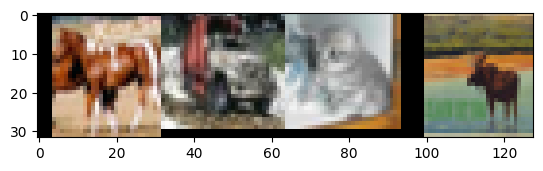

Class labels:  horse truck cat   deer 


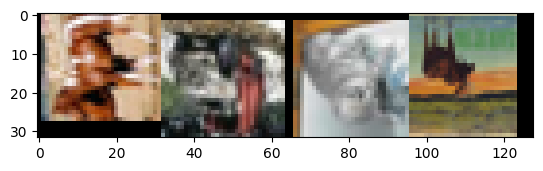

Rotation labels:  90    180   180   180  
TESTING:
Accuracy of the network on the 10000 test images: 10.03 %
Average loss on the 10000 test images: 137.205
TESTING:
Accuracy of the network on the 10000 test images: 12.74 %
Average loss on the 10000 test images: 41.124
TESTING:
Accuracy of the network on the 10000 test images: 12.41 %
Average loss on the 10000 test images: 97.052
TESTING:
Accuracy of the network on the 10000 test images: 10.11 %
Average loss on the 10000 test images: 52.140
TESTING:
Accuracy of the network on the 10000 test images: 10.66 %
Average loss on the 10000 test images: 106.446
TESTING:
Accuracy of the network on the 10000 test images: 11.60 %
Average loss on the 10000 test images: 106.173
TESTING:
Accuracy of the network on the 10000 test images: 12.29 %
Average loss on the 10000 test images: 141.146
TESTING:
Accuracy of the network on the 10000 test images: 11.38 %
Average loss on the 10000 test images: 111.914
TESTING:
Accuracy of the network on the 10000 tes

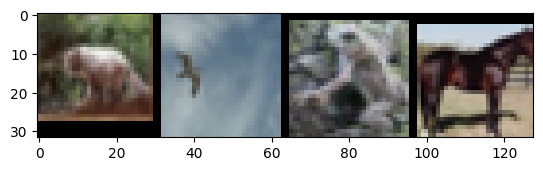

Class labels:  cat   bird  frog  horse


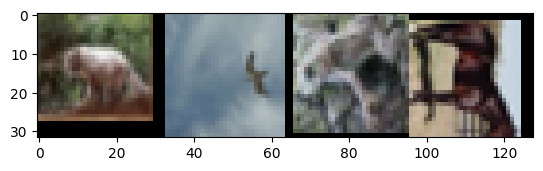

Rotation labels:  0     180   90    270  
TESTING:
Accuracy of the network on the 10000 test images: 16.67 %
Average loss on the 10000 test images: 3.409
TESTING:
Accuracy of the network on the 10000 test images: 19.69 %
Average loss on the 10000 test images: 7.038
TESTING:
Accuracy of the network on the 10000 test images: 23.42 %
Average loss on the 10000 test images: 2.061
TESTING:
Accuracy of the network on the 10000 test images: 26.71 %
Average loss on the 10000 test images: 2.063
TESTING:
Accuracy of the network on the 10000 test images: 25.67 %
Average loss on the 10000 test images: 2.752
TESTING:
Accuracy of the network on the 10000 test images: 26.02 %
Average loss on the 10000 test images: 2.912
TESTING:
Accuracy of the network on the 10000 test images: 25.29 %
Average loss on the 10000 test images: 2.073
TESTING:
Accuracy of the network on the 10000 test images: 28.75 %
Average loss on the 10000 test images: 1.958
TESTING:
Accuracy of the network on the 10000 test images: 31.

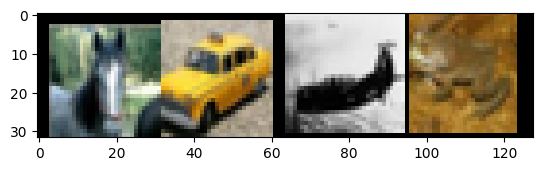

Class labels:  horse car   plane frog 


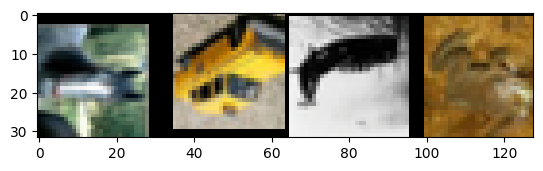

Rotation labels:  270   180   180   180  
TESTING:
Accuracy of the network on the 10000 test images: 25.66 %
Average loss on the 10000 test images: 2.585
TESTING:
Accuracy of the network on the 10000 test images: 35.22 %
Average loss on the 10000 test images: 1.770
TESTING:
Accuracy of the network on the 10000 test images: 35.84 %
Average loss on the 10000 test images: 1.736
TESTING:
Accuracy of the network on the 10000 test images: 35.29 %
Average loss on the 10000 test images: 1.788
TESTING:
Accuracy of the network on the 10000 test images: 37.68 %
Average loss on the 10000 test images: 1.698
TESTING:
Accuracy of the network on the 10000 test images: 37.70 %
Average loss on the 10000 test images: 1.724
TESTING:
Accuracy of the network on the 10000 test images: 40.27 %
Average loss on the 10000 test images: 1.602
TESTING:
Accuracy of the network on the 10000 test images: 43.12 %
Average loss on the 10000 test images: 1.576
TESTING:
Accuracy of the network on the 10000 test images: 42.

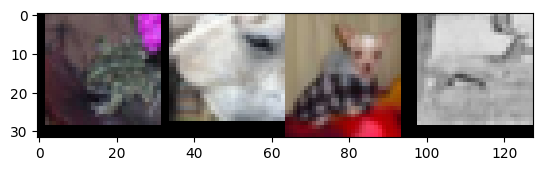

Class labels:  frog  horse dog   deer 


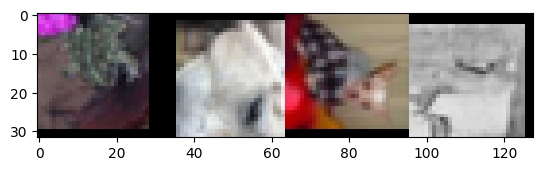

Rotation labels:  90    270   270   180  
TESTING:
Accuracy of the network on the 10000 test images: 37.68 %
Average loss on the 10000 test images: 1.614
TESTING:
Accuracy of the network on the 10000 test images: 41.16 %
Average loss on the 10000 test images: 1.611
TESTING:
Accuracy of the network on the 10000 test images: 44.33 %
Average loss on the 10000 test images: 1.511
TESTING:
Accuracy of the network on the 10000 test images: 47.40 %
Average loss on the 10000 test images: 1.444
TESTING:
Accuracy of the network on the 10000 test images: 50.94 %
Average loss on the 10000 test images: 1.353
TESTING:
Accuracy of the network on the 10000 test images: 51.36 %
Average loss on the 10000 test images: 1.349
TESTING:
Accuracy of the network on the 10000 test images: 53.49 %
Average loss on the 10000 test images: 1.293
TESTING:
Accuracy of the network on the 10000 test images: 56.14 %
Average loss on the 10000 test images: 1.265
TESTING:
Accuracy of the network on the 10000 test images: 56.

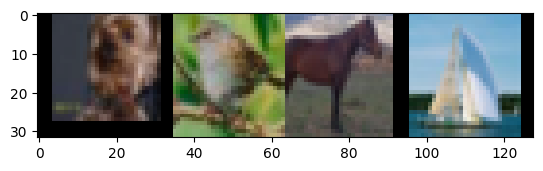

Class labels:  dog   bird  horse ship 


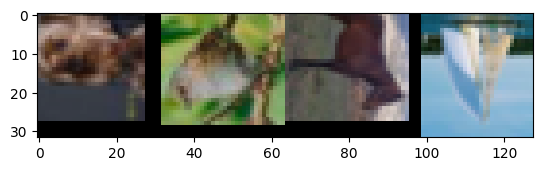

Rotation labels:  90    90    270   180  
[1,   100] loss: 1.723 acc: 33.80 time: 9.46
[1,   200] loss: 1.384 acc: 48.58 time: 9.17
[1,   300] loss: 1.257 acc: 54.29 time: 7.67
TESTING:
Accuracy of the network on the 10000 test images: 60.39 %
Average loss on the 10000 test images: 1.104
[2,   100] loss: 1.093 acc: 60.48 time: 9.44
[2,   200] loss: 1.076 acc: 61.55 time: 7.73
[2,   300] loss: 1.050 acc: 62.45 time: 9.59
TESTING:
Accuracy of the network on the 10000 test images: 64.83 %
Average loss on the 10000 test images: 0.995
[3,   100] loss: 0.985 acc: 64.65 time: 9.31
[3,   200] loss: 0.961 acc: 65.72 time: 8.15
[3,   300] loss: 0.932 acc: 67.25 time: 9.33
TESTING:
Accuracy of the network on the 10000 test images: 65.32 %
Average loss on the 10000 test images: 0.985
[4,   100] loss: 0.881 acc: 69.05 time: 7.90
[4,   200] loss: 0.882 acc: 68.54 time: 9.40
[4,   300] loss: 0.861 acc: 70.00 time: 9.61
TESTING:
Accuracy of the network on the 10000 test images: 70.80 %
Average loss on

In [20]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
subset_sizes = [20,100, 500, 1000,5000]

# Train and evaluate the model for each subset size
subset_acc_rot_mod=[]
indx=0
for num_examples_per_category in subset_sizes:
    print("subset_size:",num_examples_per_category)
    # Create the data loaders for the training and testing subsets
    model_path = 'my_model'+str(num_examples_per_category)+'.'+'pt'
    print(model_path)
    net = resnet18()
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 4)
    net.load_state_dict(torch.load(model_path))
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    #filtered_trainset = []

# Loop over each class and select 100 examples
    # for class_index in range(10):
    #     indices = torch.where(torch.tensor(trainset.targets) == class_index)[0][:num_examples_per_category]
    #     class_samples = torch.utils.data.Subset(trainset, indices)
    #     filtered_trainset.append(class_samples)

    # filtered_trainset = torch.utils.data.ConcatDataset(filtered_trainset)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=0.001)
    trainloader = torch.utils.data.DataLoader(filtered_trainset_list[indx], batch_size=batch_size,
                                         shuffle=True, num_workers=2)
    image_show()
    acc=train(net, criterion, optimizer, num_epochs=26, decay_epochs=15, init_lr=0.01, task='classification')
    subset_acc_rot_mod.append(acc)
    print(acc)
    indx+=1

In [22]:
subset_acc_rot_mod

[28.87, 49.32, 54.72, 62.86, 76.85]

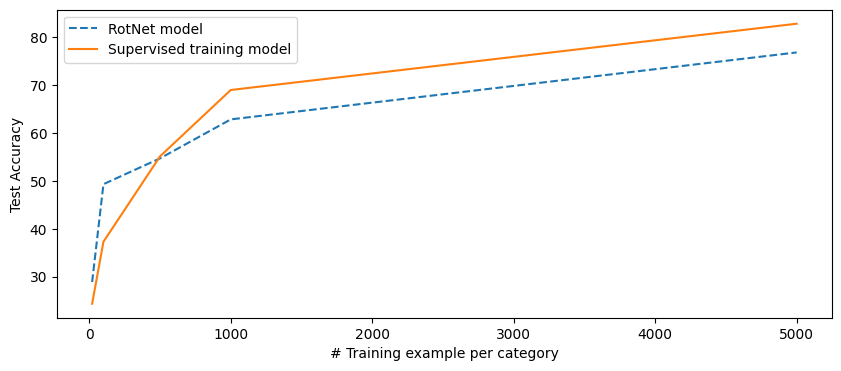

In [24]:
import matplotlib.pyplot as plt
subset_sizes = [20,100, 500, 1000,5000]
# plot the data
ax=plt.figure(figsize=(10,4))
plt.plot(subset_sizes,subset_acc_rot_mod,'--', label='RotNet model')
plt.plot(subset_sizes,subset_acc_supervised, label='Supervised training model')

# add labels and legend

plt.ylabel('Test Accuracy')
plt.xlabel('# Training example per category')
# plt.xscale()
# plt.xticks([20,100, 500, 1000,5000])
plt.legend()
plt.show()